# LeNet5 Implementation from Scratch

This is an implementation of LeNet5 from [Yann LeCun's paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) in 1998.
Without any auto-differentiate tools or other deep learning frameworks, accuracy of 98.6% on MNIST testing dataset has achieved after 20 epoches of training (93.5% after 1st epoch). 

This notebook shows the result of training after each epoches. The feature maps in the each layer are also shown after training and the F6 layer does output a figure looks like the preset ASCII bitmap.

## 0. Import Packages, Functions & Objects

The training is running with Pyton3.6 and the OS is Win10. Will try to test on other platform in the future 

In [1]:
#import package
import numpy as np 
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import time

In [4]:
from utils.LayerObjects import *
from utils.utils_func import *

# 1. Read Dataset & Preprocessing

LeNet5 was designed for classifying the hand writing digits. The MNIST is a database of handwritten digits, containing a training set of 60,000 examples, and a test set of 10,000 examples. You can auto-download the dataset by executing the `MNIST_auto_Download.py` in the folder or download from [Yann Lecun's website](http://yann.lecun.com/exdb/mnist/index.html).

## 1.1 Import Images & labels from MNIST Dataset

In [7]:
# the path of the dataset
test_image_path = r'./MNIST/t10k-images.idx3-ubyte'
test_label_path = r'./MNIST/t10k-labels.idx1-ubyte'
train_image_path = r'./MNIST/train-images.idx3-ubyte'
train_label_path = r'./MNIST/train-labels.idx1-ubyte'
trainset = (train_image_path, train_label_path)
testset = (test_image_path, test_label_path)

In [8]:
# read the dataset with readDataset()
(train_image, train_label) = readDataset(trainset)
(test_image, test_label) = readDataset(testset)
n_m, n_m_test = len(train_label), len(test_label)
print("The shape of training image:", train_image.shape)
print("The shape of testing image: ", test_image.shape)
print("Length of the training set: ", n_m)
print("Length of the training set: ", n_m_test)
print("Shape of a single image: ", train_image[0].shape)

The shape of training image: (60000, 28, 28)
The shape of testing image:  (10000, 28, 28)
Length of the training set:  60000
Length of the training set:  10000
Shape of a single image:  (28, 28)


## 1.2 Zero-padding & Normalization

Before feeding the images into the ConvNet, zero-padding with `pad=2` is used. 
The normalization method used in the original paper of LeNet5 is scaling and translating the pixel values to the range of [-0.1, 1.175], which makes the average of pixel values in each image approxiamtely equals to 0.

In [9]:
train_image_normalized_pad = normalize(zero_pad(train_image[:,:,:,np.newaxis], 2),'lenet5')
test_image_normalized_pad  = normalize(zero_pad(test_image[:,:,:,np.newaxis],  2),'lenet5')
print("The shape of training image with padding:", train_image_normalized_pad.shape)
print("The shape of testing image with padding: ", test_image_normalized_pad.shape)

The shape of training image with padding: (60000, 32, 32, 1)
The shape of testing image with padding:  (10000, 32, 32, 1)


# 2. Structure of LeNet5

The layers used here is:

**C1** → a1 → **S2** → **C3** → a2 → **S4** → **C5** → a3 → **F6** → a4 → **RBF**

where `a` denotes the squash function (activations).

The structure is much alike with the original one, but still have some differences:
1. Substitue the **sub-sampling** with **average pooling**, which is more accpetable choice without training in the layer and needless to be followed by activation funcitons. I've tried using max-pooling, it blurs the feature maps and gave low accuracy.

2. I used **momentum optimizer** when updating the weights to accelerate the training process, which wasn't used in the original LeNet5. 

In [10]:
# Designate combination of kernels and feature maps of S2.
C3_mapping = [[0,1,2],[1,2,3],[2,3,4],[3,4,5],[4,5,0],[5,0,1],\
              [0,1,2,3],[1,2,3,4],[2,3,4,5],[3,4,5,0],[4,5,0,1],[5,0,1,2],\
              [0,1,3,4],[1,2,4,5],[0,2,3,5],\
              [0,1,2,3,4,5]]

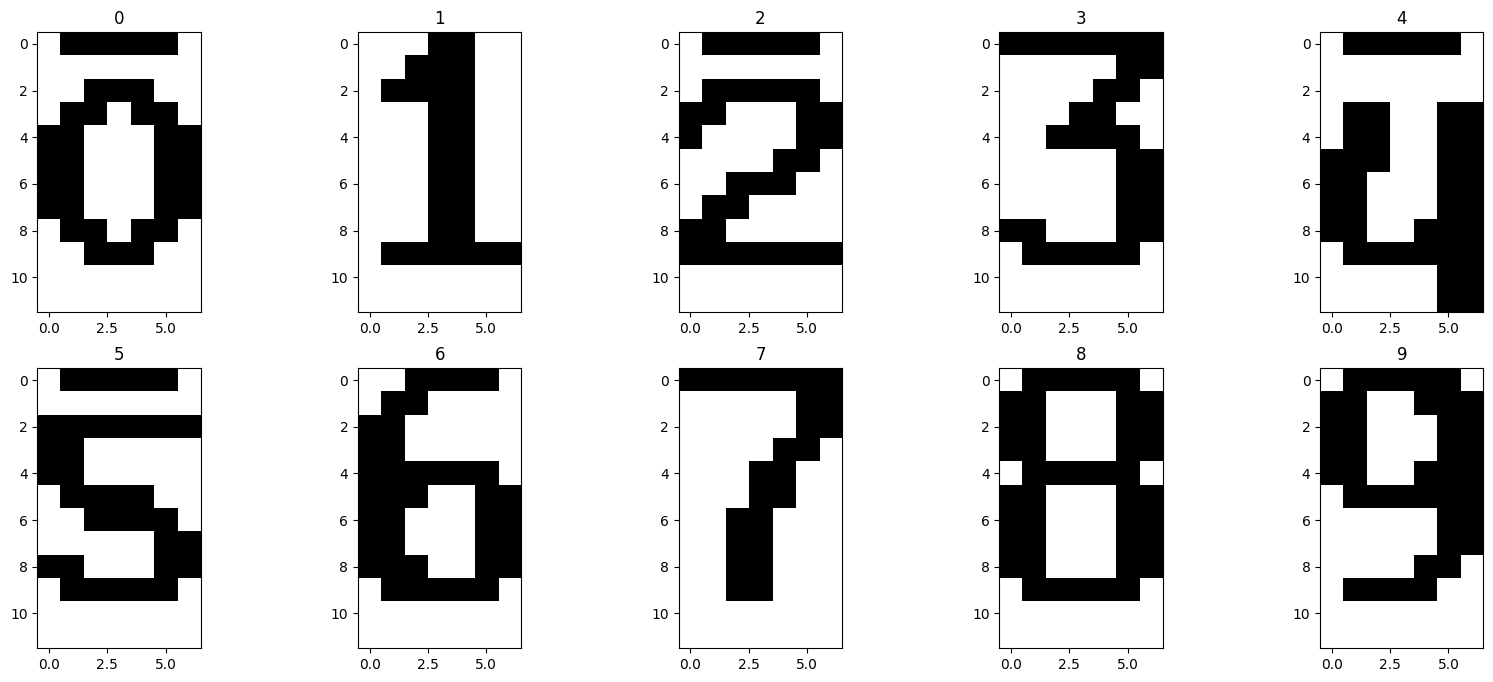

In [11]:
# The fixed weight (7x12 preset ASCII bitmaps) used in the RBF layer.
bitmap = rbf_init_weight()
fig, axarr = plt.subplots(2,5,figsize=(20,8))
for i in range(10):
    x,y = int(i/5), i%5
    axarr[x,y].set_title(str(i))
    axarr[x,y].imshow(bitmap[i,:].reshape(12,7), cmap=mpl.cm.Greys)

In [12]:
# LeNet5 object (also stored in utils/LayerObjects.py)
class LeNet5(object):
    def __init__(self):
        kernel_shape = {"C1": (5,5,1,6),
                        "C3": (5,5,6,16),    ### C3 has designated combinations
                        "C5": (5,5,16,120),  ### It's actually a FC layer
                        "F6": (120,84),
                        "OUTPUT": (84,10)}
        
        hparameters_convlayer = {"stride": 1, "pad": 0}
        hparameters_pooling   = {"stride": 2, "f": 2}        
        
        self.C1 = ConvLayer(kernel_shape["C1"], hparameters_convlayer)
        self.a1 = Activation("LeNet5_squash")
        self.S2 = PoolingLayer(hparameters_pooling, "average")
        
        self.C3 = ConvLayer_maps(kernel_shape["C3"], hparameters_convlayer, C3_mapping)
        self.a2 = Activation("LeNet5_squash")
        self.S4 = PoolingLayer(hparameters_pooling, "average")
        
        self.C5 = ConvLayer(kernel_shape["C5"], hparameters_convlayer)
        self.a3 = Activation("LeNet5_squash")

        self.F6 = FCLayer(kernel_shape["F6"])
        self.a4 = Activation("LeNet5_squash")
        
        self.Output = RBFLayer(bitmap)
        
    def Forward_Propagation(self, input_image, input_label, mode): 
        self.label = input_label
        self.C1_FP = self.C1.foward_prop(input_image)
        self.a1_FP = self.a1.foward_prop(self.C1_FP)
        self.S2_FP = self.S2.foward_prop(self.a1_FP)

        self.C3_FP = self.C3.foward_prop(self.S2_FP)
        self.a2_FP = self.a2.foward_prop(self.C3_FP)
        self.S4_FP = self.S4.foward_prop(self.a2_FP)

        self.C5_FP = self.C5.foward_prop(self.S4_FP)
        self.a3_FP = self.a3.foward_prop(self.C5_FP)

        self.flatten = self.a3_FP[:,0,0,:]
        self.F6_FP = self.F6.foward_prop(self.flatten)
        self.a4_FP = self.a4.foward_prop(self.F6_FP)  
        
        # output sum of the loss over mini-batch when mode = 'train'
        # output tuple of (0/1 error, class_predict) when mode = 'test'
        out  = self.Output.foward_prop(self.a4_FP, input_label, mode) 

        return out 
        
    def Back_Propagation(self, momentum, weight_decay):
        dy_pred = self.Output.back_prop()
        
        dy_pred = self.a4.back_prop(dy_pred)
        F6_BP = self.F6.back_prop(dy_pred, momentum, weight_decay)
        reverse_flatten = F6_BP[:,np.newaxis,np.newaxis,:]
        
        reverse_flatten = self.a3.back_prop(reverse_flatten) 
        C5_BP = self.C5.back_prop(reverse_flatten, momentum, weight_decay)
        
        S4_BP = self.S4.back_prop(C5_BP)
        S4_BP = self.a2.back_prop(S4_BP)
        C3_BP = self.C3.back_prop(S4_BP, momentum, weight_decay) 
        
        S2_BP = self.S2.back_prop(C3_BP)
        S2_BP = self.a1.back_prop(S2_BP)  
        C1_BP = self.C1.back_prop(S2_BP, momentum, weight_decay)
        
    # Stochastic Diagonal Levenberg-Marquaedt method for determining the learning rate before the beginning of each epoch
    def SDLM(self, mu, lr_global):
        d2y_pred = self.Output.SDLM()
        d2y_pred = self.a4.SDLM(d2y_pred)
        
        F6_SDLM = self.F6.SDLM(d2y_pred, mu, lr_global)
        reverse_flatten = F6_SDLM[:,np.newaxis,np.newaxis,:]
        
        reverse_flatten = self.a3.SDLM(reverse_flatten) 
        C5_SDLM = self.C5.SDLM(reverse_flatten, mu, lr_global)
        
        S4_SDLM = self.S4.SDLM(C5_SDLM)
        S4_SDLM = self.a2.SDLM(S4_SDLM)
        C3_SDLM = self.C3.SDLM(S4_SDLM, mu, lr_global)
        
        S2_SDLM = self.S2.SDLM(C3_SDLM)
        S2_SDLM = self.a1.SDLM(S2_SDLM)  
        C1_SDLM = self.C1.SDLM(S2_SDLM, mu, lr_global)

In [13]:
ConvNet = LeNet5()

# 3. Training & Testing

## 3.1 Hyperparameters

Stochastic Diagonal Levenberg-Marquaedt method is used in the original LeNet5. However, the resulting range of learning rates is much smaller than the one given in the paper (maybe bugs exist in the SDLM code). Therefore, 100x global learning rates are used here.


Momentum (0.9) is used to accelerate the convergence (reduce loss faster). Overfitting was not observed in the original LeNet5, so weight decay is set 0.


The original paper didn't mention the batch size used in SGD (seems to be 1 but not sure), but size of 256 is used.

In [14]:
# Number of epoches & learning rate in the original paper
epoch_orig, lr_global_orig = 20, np.array([5e-4]*2 + [2e-4]*3 + [1e-4]*3 + [5e-5]*4 + [1e-5]*8) 

# Number of epoches & learning rate I used
epoches, lr_global_list = epoch_orig, lr_global_orig*100

momentum = 0.9
weight_decay = 0
batch_size = 256

## 3.2 Start Training

In [16]:
#Training loops
st = time.time()
cost_last, count = np.inf, 0
err_rate_list = []
for epoch in range(0,epoches):
    print("---------- epoch", epoch+1, "begin ----------")
    
    # Stochastic Diagonal Levenberg-Marquaedt method for determining the learning rate 
    (batch_image, batch_label) = random_mini_batches(train_image_normalized_pad, train_label, mini_batch_size = 500, one_batch=True)
    ConvNet.Forward_Propagation(batch_image, batch_label, 'train')
    lr_global = lr_global_list[epoch]
    ConvNet.SDLM(0.02, lr_global)
    
    # print info
    print("global learning rate:", lr_global)
    print("learning rates in trainable layers:", np.array([ConvNet.C1.lr, ConvNet.C3.lr, ConvNet.C5.lr, ConvNet.F6.lr]))
    print("batch size:", batch_size)
    print("Momentum:",momentum,", weight decay:",weight_decay)
    
    #loop over each batch
    ste = time.time()
    cost = 0
    mini_batches = random_mini_batches(train_image_normalized_pad, train_label, batch_size)
    for i in range(len(mini_batches)):
        batch_image, batch_label = mini_batches[i]
        
        loss = ConvNet.Forward_Propagation(batch_image, batch_label, 'train')     
        cost += loss
        
        ConvNet.Back_Propagation(momentum, weight_decay) 

        # print progress
        if i%(int(len(mini_batches)/100))==0:
            sys.stdout.write("\033[F")   #CURSOR_UP_ONE
            sys.stdout.write("\033[K")   #ERASE_LINE
            print ("progress:", int(100*(i+1)/len(mini_batches)), "%, ", "cost =", cost, end='\r')
    sys.stdout.write("\033[F")   #CURSOR_UP_ONE
    sys.stdout.write("\033[K")   #ERASE_LINE
    
    print ("Done, cost of epoch", epoch+1, ":", cost,"                                             ")
    
    error01_train, _ = ConvNet.Forward_Propagation(train_image_normalized_pad, train_label, 'test')  
    error01_test, _  = ConvNet.Forward_Propagation(test_image_normalized_pad,  test_label,  'test')     
    err_rate_list.append([error01_train/60000, error01_test/10000])
    print("0/1 error of training set:",  error01_train, "/", len(train_label))
    print("0/1 error of testing set: ",  error01_test,  "/", len(test_label))
    print("Time used: ",time.time() - ste, "sec")
    print("---------- epoch", epoch+1, "end ------------")
    with open('model_data_'+str(epoch)+'.pkl', 'wb') as output:
        pickle.dump(ConvNet, output, pickle.HIGHEST_PROTOCOL)
    # %notebook -e foo.ipynb
    
err_rate_list = np.array(err_rate_list).T
print("Total time used: ", time.time() - st, "sec")

---------- epoch 1 begin ----------
global learning rate: 0.05
learning rates in trainable layers: [1.02997186e-05 1.63056979e-05 2.89130571e-05 3.00372827e-05]
batch size: 256
Momentum: 0.9 , weight decay: 0
Done, cost of epoch 1 : 707989.1330586754                                              
0/1 error of training set: 4143 / 60000
0/1 error of testing set:  649 / 10000
Time used:  180.8119878768921 sec
---------- epoch 1 end ------------


UsageError: unrecognized arguments: -e


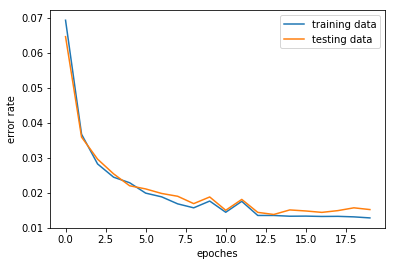

In [30]:
# This shows the error rate of training and testing data after each epoch
x = np.arange(epoches)
plt.xlabel('epoches')
plt.ylabel('error rate')
plt.plot(x, err_rate_list[0])
plt.plot(x, err_rate_list[1])
plt.legend(['training data', 'testing data'], loc='upper right')
plt.show()

## 3.3 Testing

Change models here and try out their accuracy.

In [24]:
# save model
#with open('model_data.pkl', 'wb') as output:
#    pickle.dump(ConvNet, output, pickle.HIGHEST_PROTOCOL)

In [26]:
# read model
with open('model_data_13.pkl', 'rb') as input_:
    ConvNet = pickle.load(input_)

In [27]:
test_image_normalized_pad = normalize(zero_pad(test_image[:,:,:,np.newaxis], 2), 'lenet5')
error01, class_pred = ConvNet.Forward_Propagation(test_image_normalized_pad, test_label, 'test')
#print(class_pred)
print("error rate:", error01/len(class_pred))

error rate: 0.0138


# 4. Insight of Layers

## 4.1 Feature maps of each layer

The 1st cell choose a random instance from the training data. Running over following cells shows you its feature maps in different layers. You can see that it eventually gives a result resembles to the pre-determined weight in RBF layer.

Correct label: 3
Predict label: 3


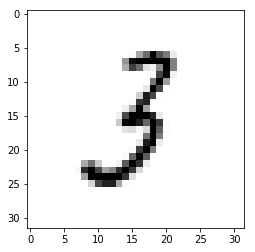

In [32]:
index = np.random.randint(60000,size=2)
train_image_sample = train_image_normalized_pad[index,:,:,:]
train_label_sample = train_label[index]
print("Correct label:",train_label_sample[0])
plt.imshow(train_image_sample[0,:,:,0], cmap=mpl.cm.Greys)
_, pred = ConvNet.Forward_Propagation(train_image_sample, train_label_sample, 'test')
print("Predict label:",pred[0])

Feature maps of C1


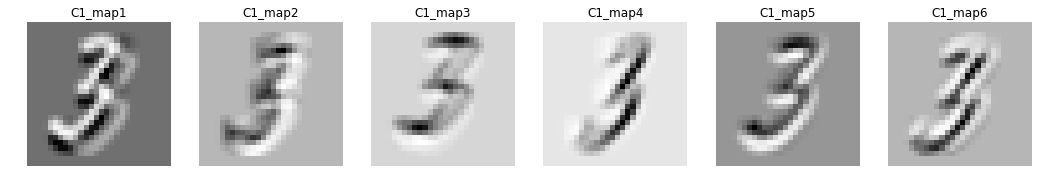

In [71]:
# Feature maps of C1
print("Feature maps of C1")
C1map = ConvNet.C1_FP[0]
fig, axarr = plt.subplots(1,6,figsize=(18,9))

for j in range(6):
    axarr[j].axis('off') 
    axarr[j].set_title( 'C1_map'+str(j+1))
    axarr[j].imshow(C1map[:,:,j], cmap=mpl.cm.Greys)

Feature maps of a1


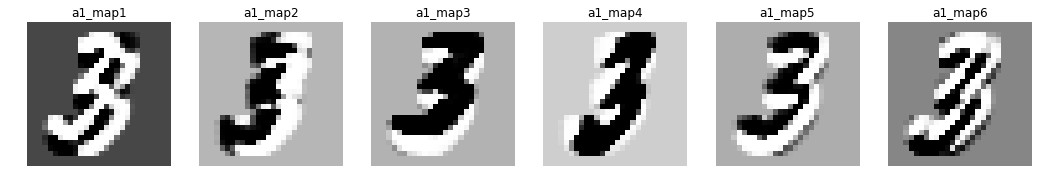

In [75]:
a1map = ConvNet.a1_FP[0]
print("Feature maps of a1")
fig, axarr = plt.subplots(1,6,figsize=(18,9))
for j in range(6):
    axarr[j].axis('off') 
    axarr[j].set_title( 'a1_map'+str(j+1))
    axarr[j].imshow(a1map[:,:,j], cmap=mpl.cm.Greys)

Feature maps of S2


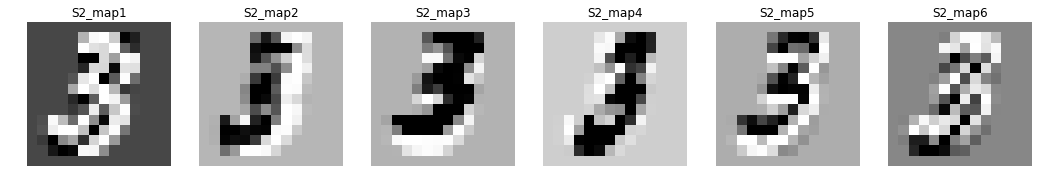

In [77]:
S2map = ConvNet.S2_FP[0]
print("Feature maps of S2")
# Feature maps of C1
fig, axarr = plt.subplots(1,6,figsize=(18,9))
for j in range(6):
    axarr[j].axis('off') 
    axarr[j].set_title( 'S2_map'+str(j+1))
    axarr[j].imshow(S2map[:,:,j], cmap=mpl.cm.Greys)

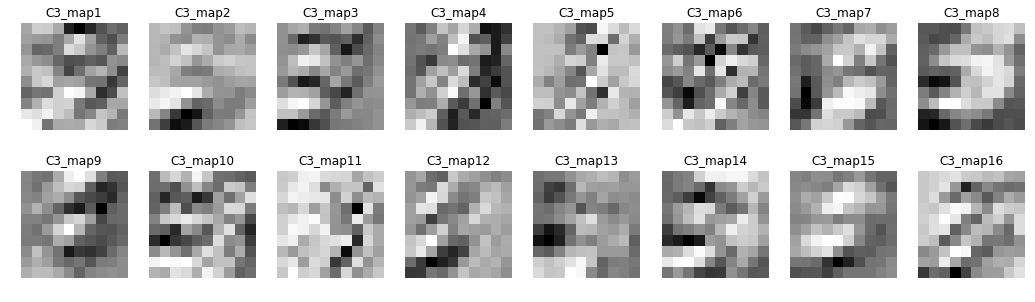

In [83]:
# Feature maps of C3
C3map = ConvNet.C3_FP[0]
fig, axarr = plt.subplots(2,8,figsize=(18,5))

for j in range(16):
    x,y = int(j/8), j%8
    axarr[x,y].axis('off') 
    axarr[x,y].set_title( 'C3_map'+str(j+1))
    axarr[x,y].imshow(C3map[:,:,j], cmap=mpl.cm.Greys)

Feature maps of a2


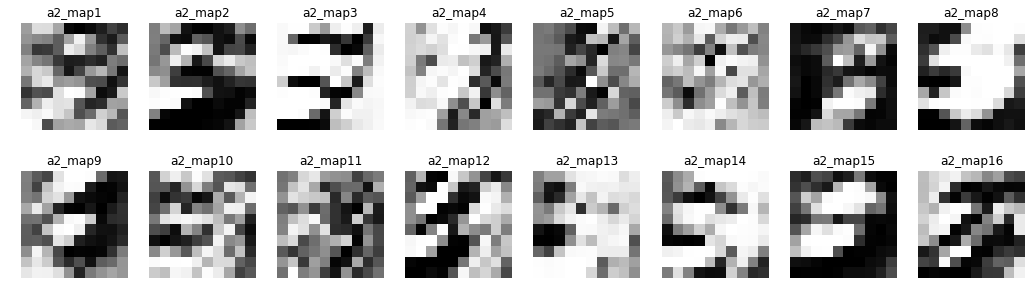

In [85]:
# Feature maps of a2
print("Feature maps of a2")
a2map = ConvNet.a2_FP[0]
fig, axarr = plt.subplots(2,8,figsize=(18,5))

for j in range(16):
    x,y = int(j/8), j%8
    axarr[x,y].axis('off') 
    axarr[x,y].set_title( 'a2_map'+str(j+1))
    axarr[x,y].imshow(a2map[:,:,j], cmap=mpl.cm.Greys)

Feature maps of S4


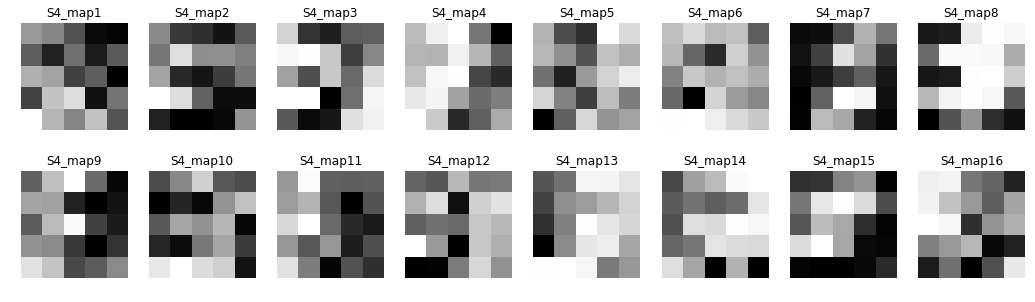

In [88]:
# Feature maps of S4
print("Feature maps of S4")
S4map = ConvNet.S4_FP[0]
fig, axarr = plt.subplots(2,8,figsize=(18,5))

for j in range(16):
    x,y = int(j/8), j%8
    axarr[x,y].axis('off') 
    axarr[x,y].set_title( 'S4_map'+str(j+1))
    axarr[x,y].imshow(S4map[:,:,j], cmap=mpl.cm.Greys)

Feature maps of C5


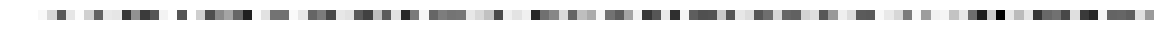

In [92]:
# Feature maps of C5
print("Feature maps of C5")
C5map = (ConvNet.C5_FP[0])[0]
plt.figure(figsize=(20,10))
plt.axis('off') 
plt.imshow(C5map, cmap=mpl.cm.Greys)

Feature maps of F6


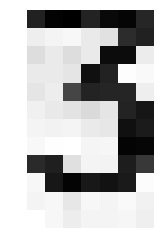

In [60]:
# Feature maps of F6
print("Feature maps of F6")
F6map = (ConvNet.F6_FP[0]).reshape(12,7)
plt.axis('off') 
plt.imshow(F6map, cmap=mpl.cm.Greys)

Feature maps of a4


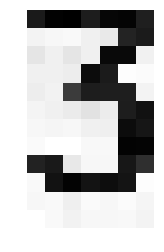

In [61]:
# Feature maps of a4
print("Feature maps of a4")
a4map = (ConvNet.a4_FP[0]).reshape(12,7)
plt.axis('off') 
plt.imshow(a4map, cmap=mpl.cm.Greys)

## 4.2 Kernels of C1, C3 & C5
Actually, knowing how the kernels look like doesn't really important since they are tuned by the training process (So I put this section at the end).

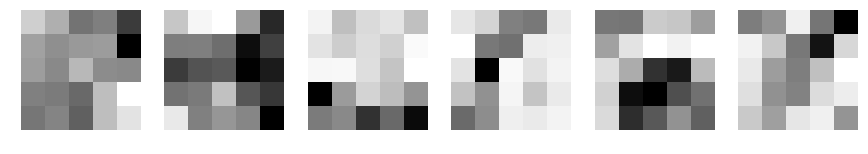

In [33]:
# The filters of C1
fig, axarr = plt.subplots(1,6,figsize=(15,15))
for i in range(6):
    axarr[i].axis('off')
    axarr[i].imshow(ConvNet.C1.weight[:,:,0,i], cmap=mpl.cm.Greys)

kernels of C3


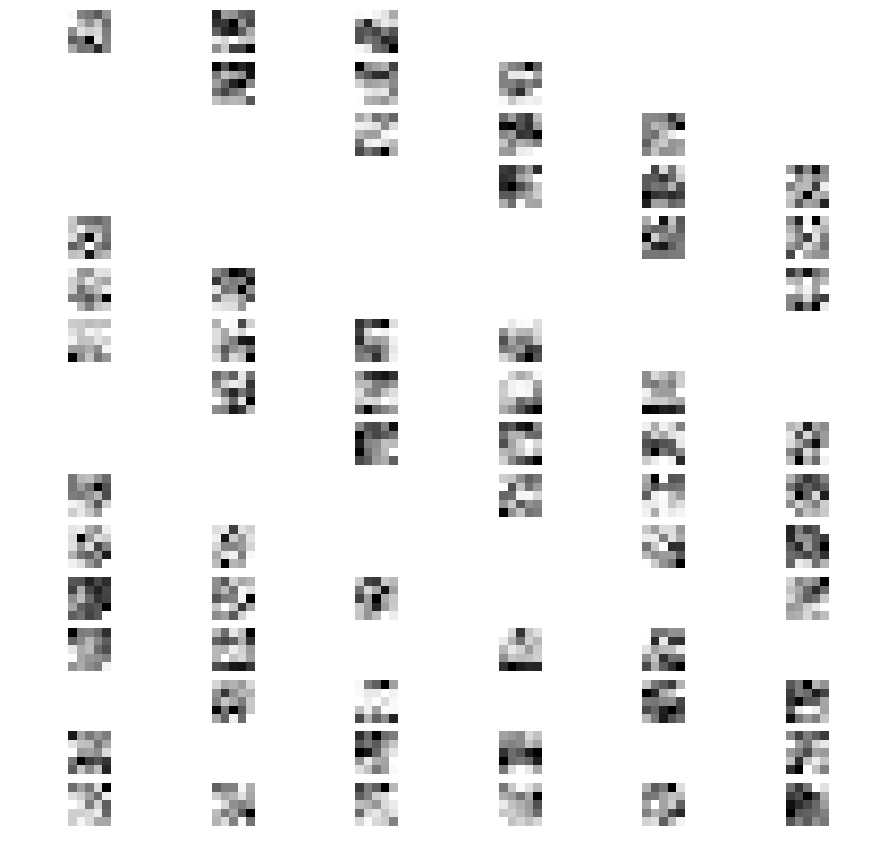

In [11]:
# The filters of C3
print("kernels of C3")
fig, axarr = plt.subplots(16,6,figsize=(15,15))
C3_kernel = np.array(ConvNet.C3.wb)[:,0].T
for i in range(16):
    k = 0
    for j in range(6):
        axarr[i,j].axis('off')
        if j in (C3_mapping[i]):      
            axarr[i,j].imshow(C3_kernel[i][:,:,k,0], cmap=mpl.cm.Greys)
            k = k+1

In [ ]:
# The filters of C5
# There are a lot of images so didn't save the result here. Run this cell to print out if you want to take a look.
print("kernels of C5")
fig, axarr = plt.subplots(120,16,figsize=(15,200))
C5_weight = np.array(ConvNet.C5.weight)
for i in range(120*16):
    x, y = int(i/16), i%16
    axarr[x,y].axis('off')
    axarr[x,y].imshow(C5_weight[:,:,y,x], cmap=mpl.cm.Greys)